
My objective in this module is to break the code of sentiment analysis, i can use a library like textblob, but i want to do it using train model.

Training your own model using the Sentiment140 dataset http://help.sentiment140.com/for-students/ By looking at the description of the dataset from the link, the information on each field can be found

0 — the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1 — the id of the tweet (2087)
2 — the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3 — the query (lyx). If there is no query, then this value is NO_QUERY.
4 — the user that tweeted (robotickilldozr)
5 — the text of the tweet (Lyx is cool)



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer


In [196]:


cols = ['sentiment','id','date','query_string','user','text']

train_df=pd.read_csv("training.1600000.processed.noemoticon.csv",header=None,names=cols,encoding='latin-1')


train_df.head()

#To count different type of sentiments in the data set

train_df['sentiment'].value_counts()



4    800000
0    800000
Name: sentiment, dtype: int64

Out of 1.6 Million entries, 50% are positive and 50% are negative, there are no neutral values and there are no null values 

In [ ]:
train_df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [ ]:
train_df[train_df.sentiment==0].head()

In [ ]:
train_df[train_df.sentiment==4].head()

Step 1 - Data preparation 

In [ ]:
# calculating length of the text
train_df['text_length']=[len(t) for t in train_df.text]

In [ ]:
#Let's see the distribution of the lenght
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(train_df.text_length)
plt.show()

It is not usual to have text lenght of a tweet more than 140, it could be due to HTML encoding which needs to be decoded and junk characters, 

In [ ]:
train_df[train_df['text_length']>140].head()

I read in a blogpost about pandas profilling, using pandas_profiling module, let's try that

In [ ]:
pip install pandas_profiling

In [ ]:
import pandas_profiling

train_df.profile_report()


Wow' it's so cool, I get so many insights about my data, below are the points i observe 

Good part, there are no null values, our main field text has >99% unique values
Bad part, our text has HTML encoding, # tags, @twitter handles, URL links, lets remove them


In [ ]:
train_df.text[226]

It is risky to remove complete # tags, so i will only remove #

Cleaning in this order 
  1. HTML decoding - Souping using beautifulsoup
  2. url address(‘http:’pattern) removing
  3. twitter handles removing
  4. url address(‘www.'pattern) removing
  5. lower-case conversion
  6. negation handling (converting can't to can not, aren't to are not and so on)
  7. removing numbers and special character
  8. tokenizing and joining


In [ ]:
pat_handle=r'@[A-Za-z0-9_]+' # @twitter handles  https://regex101.com/r/R5UYLl/1
pat_url=r'https?:\/\/?[^ ]+' #http or https urls https://regex101.com/r/R5UYLl/1
pat_www=r'www.[^ ]+' # all www urls https://regex101.com/r/R5UYLl/1

combined_pat=r'|'.join((pat_handle,pat_url))

negation_dict={"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

pat_neg=re.compile(r'\b('+'|'.join(negation_dict.keys())+r')\b')

tok = WordPunctTokenizer()

print(pat_neg)

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
        
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(pat_www, '', stripped)
    lower_case = stripped.lower()
    neg_handled = pat_neg.sub(lambda x: negation_dict[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

nums = [0,400000,800000,1200000,1600000]
print("Cleaning and parsing the tweets...\n")

for i in range(nums[0],nums[1]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                  
    clean_tweet_texts.append(tweet_cleaner(train_df['text'][i]))


In [ ]:
len(clean_tweet_texts)

In [ ]:
clean_tweet_texts = []
for j in range(0,len(nums)-1):
    for i in range(nums[j],nums[j+1]):
        if( (i+1)%10000 == 0 ):
            print("Tweets %d of %d has been processed" % ( i+1, nums[j+1] ))                                                                  
        clean_tweet_texts.append(tweet_cleaner(train_df['text'][i]))


In [ ]:
train_df_cleaned=pd.DataFrame(clean_tweet_texts,columns=['text'])
train_df_cleaned['sentiment_target']=train_df['sentiment']
train_df_cleaned.head()


In [ ]:
train_df_cleaned['sentiment_target'].value_counts()

In [ ]:
train_df_cleaned.to_csv('cleaned_tweets.csv')

In [ ]:
train_df_cleaned['length']=[len(x) for x in train_df_cleaned.text]

In [ ]:
train_df_cleaned.info()

In [ ]:
train_df_cleaned[train_df_cleaned['length']>140]

Wohoo, we reduced the length of all the tweets, except one, which should be ok

now, we will be moving towards visualizing our data, Visualization is very important step here, because it would help us identifying some patterns about the tweets

Let's first create the famous WordCloud

In [65]:
#Loading the cleaned tweets into a new dataframe

new_df=pd.read_csv("cleaned_tweets.csv")

new_df.head()

new_df.drop("Unnamed: 0",axis=1)




text  sentiment_target
0        awww that bummer you shoulda got david carr of...                 0
1        is upset that he can not update his facebook b...                 0
2        dived many times for the ball managed to save ...                 0
3           my whole body feels itchy and like its on fire                 0
4        no it not behaving at all mad why am here beca...                 0
5                                       not the whole crew                 0
6                                                 need hug                 0
7        hey long time no see yes rains bit only bit lo...                 0
8                                nope they did not have it                 0
9                                             que me muera                 0
10                   spring break in plain city it snowing                 0
11                                 just re pierced my ears                 0
12       could not bear to watch it and thought the ua ...                 0
13       it it counts idk why did either you never talk...                 0
14       would ve been the first but did not have gun n...                 0
15       wish got to watch it with you miss you and how...                 0
16       hollis death scene will hurt me severely to wa...                 0
17                                     about to file taxes                 0
18       ahh ive always wanted to see rent love the sou...                 0
19       oh dear were you drinking out of the forgotten...                 0
20        was out most of the day so did not get much done                 0
21       one of my friend called me and asked to meet w...                 0
22                              baked you cake but ated it                 0
23                     this week is not going as had hoped                 0
24                                 blagh class at tomorrow                 0
25               hate when have to call and wake people up                 0
26       just going to cry myself to sleep after watchi...                 0
27                                   im sad now miss lilly                 0
28       ooooh lol that leslie and ok will not do it ag...                 0
29       meh almost lover is the exception this track g...                 0
...                                                    ...               ...
1599970   thanks thanks that was just what was looking for                 4
1599971  thanks martin not the most imaginative interfa...                 4
1599972                            congrats mike way to go                 4
1599973                    omg office space wanna steal it                 4
1599974  ahaha nooo you were just away from everyone el...                 4
1599975  hey baack and thanks so much for all those kin...                 4
1599976     yeah my conscience would be clear in that case                 4
1599977               thats my girl dishing out the advice                 4
1599978                                        second that                 4
1599979                                      in the garden                 4
1599980         jo jen by nemuselo zrovna holce ael co nic                 4
1599981                     another commenting contest yay                 4
1599982  figured out how to see my tweets and facebook ...                 4
1599983  theri tomorrow drinking coffee talking about o...                 4
1599984  you heard it here first we re having girl hope...                 4
1599985  if ur the lead singer in band beware falling p...                 4
1599986                            too much ads on my blog                 4
1599987  neveer think that you both will get on well wi...                 4
1599988  ha good job that right we gotta throw that big...                 4
1599989                              im glad ur doing well                 4
1599990                                wooooo xbox

In [66]:
new_df.isnull().any(axis=0)

Unnamed: 0          False
text                 True
sentiment_target    False
dtype: bool

In [67]:
new_df.dropna(inplace=True)

In [68]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596040 entries, 0 to 1599999
Data columns (total 3 columns):
Unnamed: 0          1596040 non-null int64
text                1596040 non-null object
sentiment_target    1596040 non-null int64
dtypes: int64(2), object(1)
memory usage: 48.7+ MB


In [69]:
from wordcloud import WordCloud

Let's first make wordcloud for positive tweets 

In [70]:
pos_tweets=new_df[new_df['sentiment_target']==4]
pos_string=[]

for t in pos_tweets.text:
    pos_string.append(t)



In [71]:
print(pos_string[0:4])

['love guys the best', 'im meeting up with one of my besties tonight cant wait girl talk', 'thanks for the twitter add sunisa got to meet you once at hin show here in the dc area and you were sweetheart', 'being sick can be really cheap when it hurts too much to eat real food plus your friends make you soup']


In [72]:
#concatenatic all the words separated by a space
pos_string=pd.Series(pos_string).str.cat(sep=' ')

In [73]:
print(pos_string[0:30])

love guys the best im meeting 


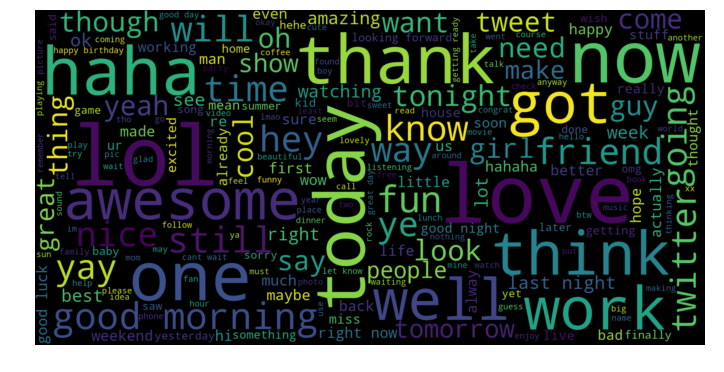

In [74]:
wordcloud_pos=WordCloud(width=1600,height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_pos,interpolation="bilinear")
plt.axis("off")
plt.show()

Words like Awesome, thank, love great nice etc are giving a true positive sense, However let's build the same word cloud for negative tweets

In [75]:
neg_tweets=new_df[new_df['sentiment_target']==0]
neg_string=[]

for t in neg_tweets.text:
    neg_string.append(t)
    
neg_string=pd.Series(neg_string).str.cat(sep=' ')




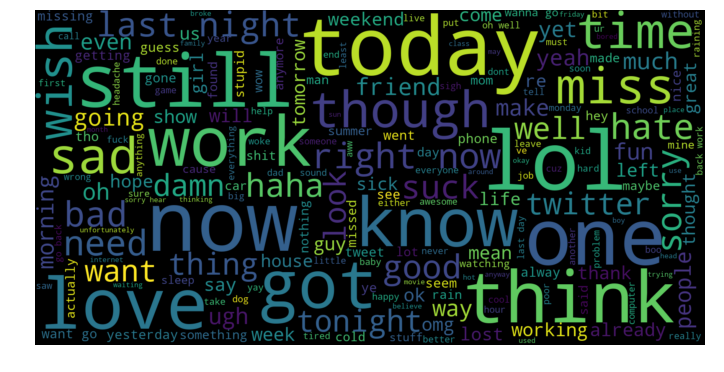

In [76]:
wordcloud_neg=WordCloud(width=1600,height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_neg,interpolation="bilinear")
plt.axis("off")
plt.show()

Neutral words = Today, Time, work , now 
Positive words - love 
negative words = hate, bad, miss, sorry

some words quite common in both positive and negative clouds are 

work - Neutral word
today 

it implies that we need to do more analysis on the words, lets find the Term frequency using count vectorizer 


In [77]:
from sklearn.feature_extraction.text import CountVectorizer
cvec=CountVectorizer()
cvec.fit(new_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [78]:
len(cvec.get_feature_names())

264933

In [79]:
cvec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [80]:
neg_doc_matrix = cvec.transform(new_df[new_df.sentiment_target == 0].text)
pos_doc_matrix = cvec.transform(new_df[new_df.sentiment_target == 4].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [81]:
term_freq_df.tail()

0  1
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz                     0  1
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz                  0  3
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz                 0  1
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...  1  0
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...  1  0

In [82]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive   total
to     313162    252567  565729
the    257836    265998  523834
my     190775    125955  316730
it     157448    147786  305234
and    153958    149642  303600
you    103844    198244  302088
not    194724     86860  281584
is     133432    111190  244622
in     115542    101160  216702
for     98999    117369  216368

So we see that we have calcualted term frequence of all the terms, The indexes are the token from the tweets dataset (“Sentiment140”), and the numbers in “negative” and “positive” columns represent how many times the token appeared in negative tweets and positive tweets.


Stop words

We see that stopwords like to, the, it, is are very frequent, however they are not resulting any meaning here, they are appearing in both Positive and Negative classes, hence we should remove them now. 


In [83]:
from nltk.corpus import stopwords

In [84]:
stop=stopwords.words("english")

In [85]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [86]:
new_df['text']=new_df['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop))


In [87]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596040 entries, 0 to 1599999
Data columns (total 3 columns):
Unnamed: 0          1596040 non-null int64
text                1596040 non-null object
sentiment_target    1596040 non-null int64
dtypes: int64(2), object(1)
memory usage: 48.7+ MB


In [101]:
cvec=CountVectorizer(max_features=10000)
cvec.fit(new_df.text)
neg_df=cvec.transform(new_df[new_df.sentiment_target==0].text)
pos_df=cvec.transform(new_df[new_df.sentiment_target==4].text)

neg_tf=np.sum(neg_df,axis=0)
pos_tf=np.sum(pos_df,axis=0)

neg=np.squeeze(np.asarray(neg_tf))
pos=np.squeeze(np.asarray(pos_tf))

new_df_tf=pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()



In [102]:
new_df_tf.head()

0    1
aa     160   92
aaa     93   54
aaaa    45   29
aaaah   76   61
aaah   160  143

In [103]:
new_df_tf.columns=['negative','positive']
new_df_tf['total']=new_df_tf['negative']+new_df_tf['positive']
new_df_tf.sort_values(by='total',ascending=False).head(10)

negative  positive  total
good      29209     62118  91327
day       41374     48186  89560
get       45606     36557  82163
like      41050     37520  78570
go        45634     28377  74011
today     38116     30100  68216
work      45420     19529  64949
love      16990     47694  64684
going     33689     30939  64628
got       33408     28037  61445

The word good is more positive than negative, but interestingly the word like is almost same in both negative and positive. 


In [91]:
N=12
print(np.linspace(1,10,N))

[ 1.          1.81818182  2.63636364  3.45454545  4.27272727  5.09090909
  5.90909091  6.72727273  7.54545455  8.36363636  9.18181818 10.        ]


Let's see what are top 50 negative words

In [104]:
import plotly.graph_objects as go
import chart_studio.plotly as py

In [105]:


y_pos=np.arange(50)

# Sort top 50 Negative words

y=new_df_tf.sort_values(by='negative', ascending=False)['negative'][:50]

data_bar=[go.Bar(x=y.index,y=y)]

layout = go.Layout(title='Top 50 Negative words')

fig=go.Figure(data_bar, layout=layout)
fig.show()




In [106]:
new_df_tf=new_df_tf.drop('im')



Let's now plot the top 50 positive tweets


In [107]:
y_pos=np.arange(50)

# Sort top 50 Negative words

y=new_df_tf.sort_values(by='positive', ascending=False)['positive'][:50]

data_bar=[go.Bar(x=y.index,y=y)]

layout = go.Layout(title='Top 50 positive words')

fig=go.Figure(data_bar, layout=layout)
fig.show()


Positive words = good, love, thanks, like
neutral words = day, get, going, time, today


Let's plot Positive words on the Y axis and negative on the X axis using a scatter chart

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

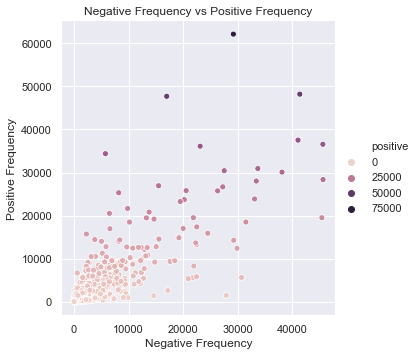

In [108]:
import seaborn as sns
#plt.figure(figsize=(8,6))
sns.set(color_codes=True)
ax = sns.relplot(x="negative", y="positive",data=new_df_tf,hue='positive')
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

The frequency scatter graph tells us that majority of words have frequency under 10,000. However, we can not determine if anything related to negativity or positivity of words. Therfore, we need to try something else. 

We should check what is the positive or negative ratio in the complete data. I will define positive ratio as 

pos_rate= Positive frequency / Total frequency 



neg_rate=Negative frequency/Total frequency






In [109]:
new_df_tf['pos_rate']=new_df_tf['positive']/new_df_tf['total']

In [110]:
new_df_tf.sort_values(by='pos_rate',ascending=False)

negative  positive  total  pos_rate
mileymonday             0       161    161  1.000000
emailunlimited          0       100    100  1.000000
dividends               0        83     83  1.000000
shareholder             1        80     81  0.987654
fuzzball                2        99    101  0.980198
recommends              3       109    112  0.973214
delongeday              6       162    168  0.964286
atcha                   3        80     83  0.963855
timestamp               3        68     71  0.957746
shaundiviney            4        89     93  0.956989
mcflyforgermany        11       221    232  0.952586
shaunjumpnow            8       153    161  0.950311
gratitude               4        76     80  0.950000
honored                10       162    172  0.941860
followfriday          169      2731   2900  0.941724
hotwords                5        74     79  0.936709
cest                    5        71     76  0.934211
congratulations       101      1410   1511  0.933157
guten                   5        67     72  0.930556
recommendation         26       342    368  0.929348
gracias                 7        91     98  0.928571
introducing             8        89     97  0.917526
welcome               620      6702   7322  0.915324
thankies                8        85     93  0.913978
blessings              27       286    313  0.913738
vip                   161      1632   1793  0.910206
whoot                   9        89     98  0.908163
blushing                8        79     87  0.908046
musicmonday            40       393    433  0.907621
debby                   7        68     75  0.906667
...                   ...       ...    ...       ...
bummed               1745        94   1839  0.051115
sobs                   79         4     83  0.048193
heartburn             121         6    127  0.047244
sniffle               125         6    131  0.045802
devastated            152         7    159  0.044025
sadder                111         5    116  0.043103
upsetting             204         9    213  0.042254
snif                   72         3     75  0.040000
twug                   74         3     77  0.038961
heartbroken           223         9    232  0.038793
carradine             223         9    232  0.038793
condolences           201         7    208  0.033654
noooooooooo            87         3     90  0.033333
unloved               117         4    121  0.033058
boohoo                197         6    203  0.029557
bts                   100         3    103  0.029126
mcmahon               202         6    208  0.028846
saddened              176         5    181  0.027624
ouchie                108         3    111  0.027027
owie                   86         2     88  0.022727
sadface               130         3    133  0.022556
farrah                541        12    553  0.021700
saddens               102         2    104  0.019231
sadd                  108         2    110  0.018182
inaperfectworld       189         0    189  0.000000
dontyouhate           106         0    106  0.000000
isplayer              210         0    210  0.000000
pakcricket             82         0     82  0.000000
neda                   97         0     97  0.000000
fawcett               379         0    379  0.000000

[9999 rows x 4 columns]

While the pos_rate should give some meaningful insights about the positivity of the word, however in this case it is not because the there are many words which have very low positive frequency and have pos_rate = 1

What if we check the positive percentage of the positive tweets 



In [129]:
new_df_tf['pos_freq_pct']=new_df_tf['positive']*1./new_df_tf['positive'].sum()
new_df_tf.sort_values(by='pos_freq_pct',ascending=False).round(6)

negative  positive  total  pos_rate  pos_freq_pct
good                29209     62118  91327  0.680171      0.013059
day                 41374     48186  89560  0.538030      0.010130
love                16990     47694  64684  0.737338      0.010027
like                41050     37520  78570  0.477536      0.007888
get                 45606     36557  82163  0.444933      0.007685
lol                 23123     36118  59241  0.609679      0.007593
thanks               5768     34374  40142  0.856310      0.007226
going               33689     30939  64628  0.478724      0.006504
time                27526     30432  57958  0.525070      0.006398
today               38116     30100  68216  0.441245      0.006328
go                  45634     28377  74011  0.383416      0.005966
got                 33408     28037  61445  0.456294      0.005894
new                 15508     26939  42447  0.634650      0.005663
one                 27262     26683  53945  0.494633      0.005609
see                 20560     25811  46371  0.556619      0.005426
know                26322     25747  52069  0.494478      0.005413
great                8197     25310  33507  0.755365      0.005321
back                33090     23869  56959  0.419056      0.005018
night               20220     23722  43942  0.539848      0.004987
well                19471     23271  42742  0.544453      0.004892
haha                 9835     21667  31502  0.687798      0.004555
morning             13770     20832  34602  0.602046      0.004379
happy                6497     20533  27030  0.759637      0.004317
work                45420     19529  64949  0.300682      0.004106
think               21881     19526  41407  0.471563      0.004105
twitter             13267     19480  32747  0.594864      0.004095
hope                14669     19200  33869  0.566890      0.004036
really              31496     18524  50020  0.370332      0.003894
fun                 10173     18520  28693  0.645454      0.003893
oh                  22494     17398  39892  0.436128      0.003658
...                   ...       ...    ...       ...           ...
heartburn             121         6    127  0.047244      0.000001
ugggh                  71         6     77  0.077922      0.000001
boohoo                197         6    203  0.029557      0.000001
booooooo               74         6     80  0.075000      0.000001
activation             90         6     96  0.062500      0.000001
mcmahon               202         6    208  0.028846      0.000001
hiks                   79         5     84  0.059524      0.000001
disapointed            88         5     93  0.053763      0.000001
saddened              176         5    181  0.027624      0.000001
ulcer                  78         5     83  0.060241      0.000001
sadder                111         5    116  0.043103      0.000001
unloved               117         4    121  0.033058      0.000001
ouchy                  71         4     75  0.053333      0.000001
ugghh                  74         4     78  0.051282      0.000001
sobs                   79         4     83  0.048193      0.000001
noooooooooo            87         3     90  0.033333      0.000001
sadface               130         3    133  0.022556      0.000001
twug                   74         3     77  0.038961      0.000001
snif                   72         3     75  0.040000      0.000001
ouchie                108         3    111  0.027027      0.000001
bts                   100         3    103  0.029126      0.000001
saddens               102         2    104  0.019231      0.000000
owie                   86         2     88  0.022727      0.000000
sadd                  108         2    110  0.018182      0.000000
fawcett               379         0    379  0.000000      0.000000
isplayer              210         0    210  0.000000      0.000000
inaperfectworld       189         0    189  0.000000      0.000000
dontyouhate           106         0    106  0.000000      0.0000

Ranking based on pos_freq_pct is same as positive frequency, the pos_freq_pct is ranging between 0 to 0.013 and pos_rate is ranging between 0 to 1, if we take arithmetic mean it would be dominated by the pos_rate, therefore we will take harmonic mean 

Since the harmonic mean of a list of numbers tends strongly toward the least elements of the list, it tends (compared to the arithmetic mean) to mitigate the impact of large outliers and aggravate the impact of small ones.” The harmonic mean H of the positive real number x1,x2,…xn is defined as

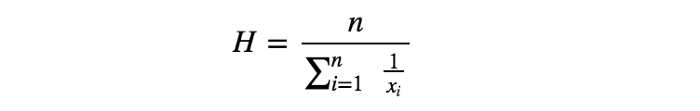

In [142]:
from scipy.stats import hmean
new_df_tf['pos_freq_hmean']=new_df_tf.apply(lambda x: (hmean([x['pos_rate'],x['pos_freq_pct']]) if (x['pos_rate']>0 and x['pos_freq_pct']>0) else 0),axis=1)
new_df_tf.sort_values(by='pos_freq_hmean',ascending=False).round(6)

negative  positive  total  pos_rate  pos_freq_pct  \
good                29209     62118  91327  0.680171      0.013059   
day                 41374     48186  89560  0.538030      0.010130   
love                16990     47694  64684  0.737338      0.010027   
like                41050     37520  78570  0.477536      0.007888   
get                 45606     36557  82163  0.444933      0.007685   
lol                 23123     36118  59241  0.609679      0.007593   
thanks               5768     34374  40142  0.856310      0.007226   
going               33689     30939  64628  0.478724      0.006504   
time                27526     30432  57958  0.525070      0.006398   
today               38116     30100  68216  0.441245      0.006328   
go                  45634     28377  74011  0.383416      0.005966   
got                 33408     28037  61445  0.456294      0.005894   
new                 15508     26939  42447  0.634650      0.005663   
one                 27262     26683  53945  0.494633      0.005609   
see                 20560     25811  46371  0.556619      0.005426   
know                26322     25747  52069  0.494478      0.005413   
great                8197     25310  33507  0.755365      0.005321   
back                33090     23869  56959  0.419056      0.005018   
night               20220     23722  43942  0.539848      0.004987   
well                19471     23271  42742  0.544453      0.004892   
haha                 9835     21667  31502  0.687798      0.004555   
morning             13770     20832  34602  0.602046      0.004379   
happy                6497     20533  27030  0.759637      0.004317   
think               21881     19526  41407  0.471563      0.004105   
twitter             13267     19480  32747  0.594864      0.004095   
work                45420     19529  64949  0.300682      0.004106   
hope                14669     19200  33869  0.566890      0.004036   
fun                 10173     18520  28693  0.645454      0.003893   
really              31496     18524  50020  0.370332      0.003894   
oh                  22494     17398  39892  0.436128      0.003658   
...                   ...       ...    ...       ...           ...   
booooooo               74         6     80  0.075000      0.000001   
activation             90         6     96  0.062500      0.000001   
heartburn             121         6    127  0.047244      0.000001   
sniffle               125         6    131  0.045802      0.000001   
boohoo                197         6    203  0.029557      0.000001   
mcmahon               202         6    208  0.028846      0.000001   
ulcer                  78         5     83  0.060241      0.000001   
hiks                   79         5     84  0.059524      0.000001   
disapointed            88         5     93  0.053763      0.000001   
sadder                111         5    116  0.043103      0.000001   
saddened              176         5    181  0.027624      0.000001   
ouchy                  71         4     75  0.053333      0.000001   
ugghh                  74         4     78  0.051282      0.000001   
sobs                   79         4     83  0.048193      0.000001   
unloved               117         4    121  0.033058      0.000001   
snif                   72         3     75  0.040000      0.000001   
twug                   74         3     77  0.038961      0.000001   
noooooooooo            87         3     90  0.033333      0.000001   
bts                   100         3    103  0.029126      0.000001   
ouchie                108         3    111  0.027027      0.000001   
sadface               130         3    133  0.022556      0.000001   
owie                   86         2     88  0.022727      0.000000   
saddens               102         2    104  0.019231      0.000000   
sadd                  108         2    110  0.018182      0.000000   
isplayer              210         0    210  0.000000      0.000000   
fawcett               379  

Again, hmean is raking the words is same as pos_freq_pct, lets plot pos_rate, pos_freq_pct and pos_freq_hmean

In [157]:
new_df_tf=new_df_tf.sort_values(by='pos_freq_hmean', ascending=False)

fig = go.Figure()
fig.add_trace(go.Scatter(x=new_df_tf.index, y=new_df_tf.pos_freq_hmean,name='pos_freq_hmean'))
fig.add_trace(go.Scatter(x=new_df_tf.index, y=new_df_tf.pos_freq_pct,name='pos_freq_pct'))
fig.add_trace(go.Scatter(x=new_df_tf.index, y=new_df_tf.pos_rate,name='pos_rate'))

fig.show()

when we see these graphs, we understand that all three metrics are showing same trends, and we are not getting any meaningful values. Let's calculate Cumulative Distribution Function for each of the token for pos_rate and pos_freq_pct. CDF for each of the token X will be the probability of X taking value less than x, i.e. pos_rate or pos_freq_pct. 

CDF can be explained as “distribution function of X, evaluated at x, is the probability that X will take a value less than or equal to x”.



https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [176]:

from scipy.stats import norm
new_df_tf['pos_rate_normcdf'] = norm.cdf(new_df_tf['pos_rate'],new_df_tf['pos_rate'].mean(),new_df_tf['pos_rate'].std())
new_df_tf['pos_freq_pct_normcdf'] = norm.cdf(new_df_tf['pos_freq_pct'],new_df_tf['pos_freq_pct'].mean(),new_df_tf['pos_freq_pct'].std())
new_df_tf['pos_normcdf_hmean'] = hmean([new_df_tf['pos_rate_normcdf'], new_df_tf['pos_freq_pct_normcdf']])
new_df_tf.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]


0.49896386838430407


negative  positive  total  pos_rate  pos_freq_pct  pos_freq_hmean  \
welcome       620      6702   7322  0.915324      0.001409        0.002814   
thank        2282     15736  18018  0.873349      0.003308        0.006591   
thanks       5768     34374  40142  0.856310      0.007226        0.014332   
awesome      3821     14469  18290  0.791088      0.003042        0.006060   
glad         2273      8255  10528  0.784100      0.001735        0.003463   
follow       2552      9155  11707  0.782011      0.001925        0.003840   
enjoy        1642      5876   7518  0.781591      0.001235        0.002467   
sweet        1610      5646   7256  0.778115      0.001187        0.002370   
yay          3165     10501  13666  0.768403      0.002208        0.004403   
hi           2176      7214   9390  0.768264      0.001517        0.003027   

         pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  
welcome          0.995827              0.999182           0.997501  
thank            0.991149              1.000000           0.995555  
thanks           0.988208              1.000000           0.994069  
awesome          0.967890              1.000000           0.983683  
glad             0.964570              0.999958           0.981946  
follow           0.963525              0.999994           0.981421  
enjoy            0.963312              0.996848           0.979793  
sweet            0.961508              0.995541           0.978229  
yay              0.956084              1.000000           0.977549  
hi               0.956001              0.999673           0.977350

In [179]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(x=new_df_tf.index,y=new_df_tf.pos_normcdf_hmean,mode='markers'))
fig1.show()

This looks great, we see that there is an interesting trend, the words with high cdf hmena are on the top left. Let's do similar excercise for negative words


In [181]:
new_df_tf['neg_rate']=new_df_tf['negative']/new_df_tf['total']

new_df_tf['neg_freq_pct']=new_df_tf['negative']*1./new_df_tf['negative'].sum()

new_df_tf['neg_freq_hmean']=new_df_tf.apply(lambda x: (hmean([x.neg_rate,x.neg_freq_pct]) if x.neg_rate>0 and x.neg_freq_pct>0 else 0),axis=1)

new_df_tf['neg_rate_normcdf'] = norm.cdf(new_df_tf['neg_rate'],new_df_tf['neg_rate'].mean(),new_df_tf['neg_rate'].std())
new_df_tf['neg_freq_pct_normcdf'] = norm.cdf(new_df_tf['neg_freq_pct'],new_df_tf['neg_freq_pct'].mean(),new_df_tf['neg_freq_pct'].std())
new_df_tf['neg_normcdf_hmean'] = hmean([new_df_tf['neg_rate_normcdf'], new_df_tf['neg_freq_pct_normcdf']])
new_df_tf.sort_values(by='neg_normcdf_hmean',ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_pct  pos_freq_hmean  \
sad          27911      1510  29421  0.051324      0.000317        0.000631   
hurts         7204       456   7660  0.059530      0.000096        0.000191   
sick         14617      1419  16036  0.088488      0.000298        0.000595   
sucks         9902       982  10884  0.090224      0.000206        0.000412   
poor          7333       719   8052  0.089295      0.000151        0.000302   
ugh           9056       998  10054  0.099264      0.000210        0.000419   
missing       7282       991   8273  0.119787      0.000208        0.000416   
hate         17207      2614  19821  0.131880      0.000550        0.001095   
headache      5317       421   5738  0.073371      0.000089        0.000177   
miss         30713      5676  36389  0.155981      0.001193        0.002368   

          pos_rate_normcdf  pos_freq_pct_normcdf  pos_normcdf_hmean  neg_rate  \
sad               0.002285              0.699565           0.004555  0.948676   
hurts             0.002686              0.496020           0.005342  0.940470   
sick              0.004655              0.683362           0.009248  0.911512   
sucks             0.004807              0.601056           0.009537  0.909776   
poor              0.004725              0.548967           0.009370  0.910705   
ugh               0.005668              0.604177           0.011231  0.900736   
missing           0.008150              0.602812           0.016082  0.880213   
hate              0.010022              0.860277           0.019813  0.868120   
headache          0.003507              0.488959           0.006964  0.926629   
miss              0.014896              0.995735           0.029353  0.844019   

          neg_freq_pct  neg_freq_hmean  neg_rate_normcdf  \
sad           0.005518        0.010971          0.997715   
hurts         0.001424        0.002844          0.997314   
sick          0.002890        0.005761          0.995345   
sucks         0.001957        0.003906          0.995193   
poor          0.001450        0.002895          0.995275   
ugh           0.001790        0.003573          0.994332   
missing       0.001440        0.002874          0.991850   
hate          0.003402        0.006776          0.989978   
headache      0.001051        0.002100          0.996493   
miss          0.006071        0.012056          0.985104   

          neg_freq_pct_normcdf  neg_normcdf_hmean  
sad                   1.000000           0.998856  
hurts                 0.999452           0.998382  
sick                  1.000000           0.997667  
sucks                 0.999998           0.997590  
poor                  0.999562           0.997414  
ugh                   0.999985           0.997150  
missing               0.999521           0.995671  
hate                  1.000000           0.994964  
headache              0.990484           0.993480  
miss                  1.000000           0.992496

In [182]:
fig2=go.Figure()
fig2.add_trace(go.Scatter(x=new_df_tf.index,y=new_df_tf.neg_normcdf_hmean,mode='markers'))
fig2.show()

In [195]:
fig3=go.Figure()
fig3.add_trace(go.Scatter(y=new_df_tf.pos_normcdf_hmean,x=new_df_tf.neg_normcdf_hmean,mode='markers',hovertext=new_df_tf.index,
    marker=dict(
        size=5,
        color=new_df_tf.pos_normcdf_hmean,
        cmax=new_df_tf.pos_normcdf_hmean.max(),
        cmin=new_df_tf.pos_normcdf_hmean.min(),
        colorscale="Viridis"
    )))
fig3.show()

With the above plot,we can see which word represents what by hovering over the data points. The points in the top left corner show tokens like “thank”, “welcome”,"awesome", “congrats”, etc. And some of the tokens in bottom right corner are “sad”, “hurts”, “died”, “miss”, etc. And the color of each dot is organised by Viridis color map , so yellow is the most positive, while blue is the most negative, and the color gradually goes from blue to purple to orange to yellow, as it goes from negative to positive.

